<a href="https://colab.research.google.com/github/NickyAlan/Yolo_v5-ONNX/blob/main/train_custom_yolov5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -r requirements.txt
%pip install roboflow

In [ ]:
import yaml
import torch
from roboflow import Roboflow
from IPython.display import Image, clear_output
from IPython.core.magic import register_line_cell_magic

In [ ]:
rf = Roboflow(api_key="KEY")
project = rf.workspace("rtkku").project("cat-duck")
version = project.version(2)
dataset = version.download("yolov5")

In [ ]:
with open(f"{dataset.location}/data.yaml", "r") as f :
    info = yaml.safe_load(f)
    num_classes = info["nc"]
    class_names = info["names"]

In [ ]:
info

{'names': ['cat', 'duck'],
 'nc': 2,
 'roboflow': {'license': 'MIT',
  'project': 'cat-duck',
  'url': 'https://universe.roboflow.com/rtkku/cat-duck/dataset/2',
  'version': 2,
  'workspace': 'rtkku'},
 'test': '../test/images',
 'train': 'cat-duck-2/train/images',
 'val': 'cat-duck-2/valid/images'}

In [ ]:
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 

### Rewrite .yaml to mach our dataset

In [ ]:
@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: {num_classes} # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4], 1, Concat, [1]], # cat backbone P3
    [-1, 3, C3, [256, False]], # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]], # cat head P4
    [-1, 3, C3, [512, False]], # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]], # cat head P5
    [-1, 3, C3, [1024, False]], # 23 (P5/32-large)

    [[17, 20, 23], 1, Detect, [nc, anchors]], # Detect(P3, P4, P5)
  ]

### Training

In [ ]:
%%time
!python train.py --img 416 --batch 16 --epochs 50 --data {dataset.location}/data.yaml --cfg ./models/yolov5s.yaml --weights 'yolov5s.pt' --name yolov5s_results  --cache

2024-03-29 14:07:31.393036: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 14:07:31.393115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 14:07:31.394774: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=./models/yolov5s.yaml, data=/content/yolov5/cat-duck-2/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, devi

In [ ]:
!python detect.py --weights /content/yolov5/runs/train/yolov5s_results2/weights/best.pt --img 416 --conf 0.4 --source /content/yolov5/cat-duck-2/train/images/train-image.jpg

detect: weights=['/content/yolov5/runs/train/yolov5s_results2/weights/best.pt'], source=/content/yolov5/cat-duck-2/train/images/train-image.jpg, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-295-gac6c4383 Python-3.10.12 torch-2.2.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/yolov5/cat-duck-2/train/images/train-image.jpg: 416x416 1 cat, 3 ducks, 350.8ms
Speed: 3.1ms pre-process, 350.8ms inference, 1.3ms NMS per image at shape (1, 3, 416, 416)
Results saved to runs/detect/exp2


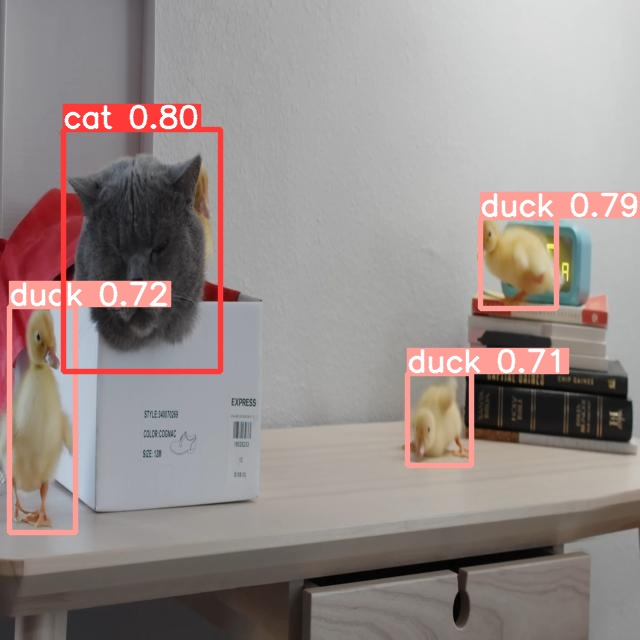

In [ ]:
Image("/content/yolov5/runs/detect/exp2/train-image.jpg")

## To ONNX model

In [ ]:
!pip install -r requirements.txt onnx onnx-simplifier onnxruntime

In [ ]:
!python export.py --weights /content/yolov5/runs/train/yolov5s_results2/weights/best.pt --include onnx

export: data=data/coco128.yaml, weights=['/content/yolov5/runs/train/yolov5s_results2/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, per_tensor=False, dynamic=False, simplify=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5 🚀 v7.0-295-gac6c4383 Python-3.10.12 torch-2.2.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from /content/yolov5/runs/train/yolov5s_results2/weights/best.pt with output shape (1, 25200, 7) (13.7 MB)

ONNX: starting export with onnx 1.16.0...
ONNX: export success ✅ 1.3s, saved as /content/yolov5/runs/train/yolov5s_results2/weights/best.onnx (27.2 MB)

Export complete (2.6s)
Results saved to /content/yolov5/runs/train/yolov5s_results2/weights
Detect:          python detect.py --weights /conten

In [ ]:
!python detect.py --weights /content/yolov5/runs/train/yolov5s_results2/weights/best.onnx --img 640 --conf 0.4 --source /content/yolov5/cat-duck-2/train/images/train-image.jpg

detect: weights=['/content/yolov5/runs/train/yolov5s_results2/weights/best.onnx'], source=/content/yolov5/cat-duck-2/train/images/train-image.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-295-gac6c4383 Python-3.10.12 torch-2.2.1+cu121 CPU

Loading /content/yolov5/runs/train/yolov5s_results2/weights/best.onnx for ONNX Runtime inference...
image 1/1 /content/yolov5/cat-duck-2/train/images/train-image.jpg: 640x640 1 cat, 3 ducks, 228.4ms
Speed: 2.9ms pre-process, 228.4ms inference, 1.4ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp4


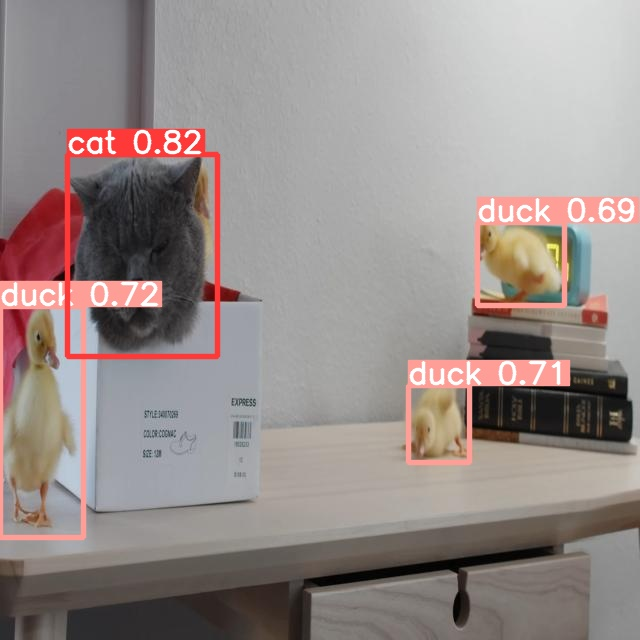

In [ ]:
Image("/content/yolov5/runs/detect/exp4/train-image.jpg")